#  Predicting minimum daily temperatures in Melbourne
Predict the minimum daily temperature for the next 7 days given the historic minimum daily averages and the 7 days leading up. Simple model performs a *tiny* **0.08 deg** better than historic averages.

In [397]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [398]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils import train_reg, plot_loss

In [403]:
PATH = "./data/Melbourne/daily-min-temperatures.txt"
with open(PATH, "r") as f:
    reader = csv.reader(f)
    header = next(reader)
    temps = []
    dates = []
    for date, temp in reader:
        temps.append(temp)
        dates.append(date)
    temps = np.array(temps, dtype="float32")
len(temps)

3650

In [427]:
print(dates[1458:1462]) # no 31st Dec due to leap year

['1984-12-29', '1984-12-30', '1985-01-01', '1985-01-02']


Mean Daily Variation: 2.544987440109253


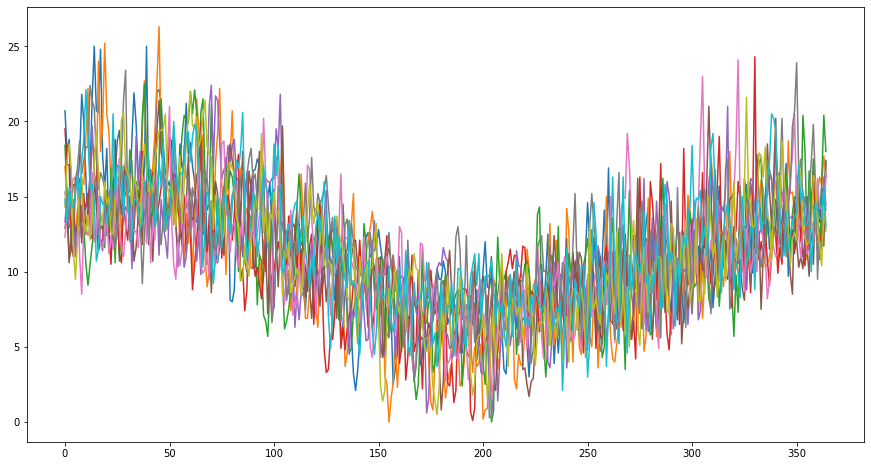

In [588]:
years = temps.reshape(-1, 365)
print(f"Mean Daily Variation: {years.std(axis=0).mean()}")
plt.figure(figsize=(15, 8))
for year in years:
    plt.plot(year)
plt.show()

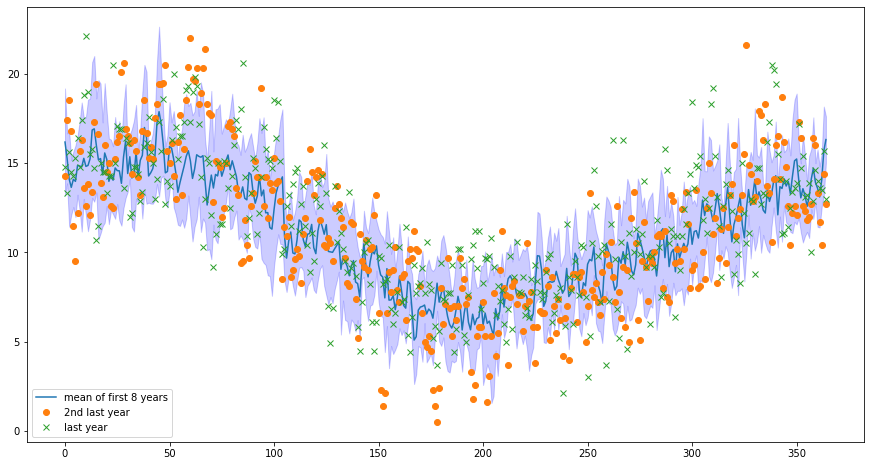

In [790]:
plt.figure(figsize=(15, 8))
m = years[:-2].mean(axis=0)
std = years[:-2].std(axis=0)
plt.plot(m, label="mean of first 8 years")
plt.fill_between(np.arange(365), m - std, m + std, color='blue', alpha=0.2)
plt.plot(years[-2], "o", label="2nd last year")
plt.plot(years[-1], "x", label="last year")
plt.legend()
plt.show()

In [791]:
def split_data(temps, dates, train_years):
    break_year = str(90 - train_years + 1)
    for i, date in enumerate(dates):
        if break_year in date:
            break    
    train = temps[:i]
    test = temps[i:]
    return train, test

In [792]:
train, test = split_data(temps, dates, 2)
train.shape, test.shape

((2920,), (730,))

In [793]:
temp_mean = train.mean()
temp_std = train.std()
train = (train - mean_temp) / temp_std
test = (test - mean_temp) / temp_std
historic_means = train.reshape((-1, 365)).mean(axis=0)
historic_means.shape

(365,)

In [794]:
PREDICT_PERIOD = 7
LEARNING_PERIOD = 7

In [795]:
def create_xy(X, means, learning_size=7):
    block_size = learning_size + PREDICT_PERIOD
    blocks = len(X) // (block_size)
    x = np.zeros((blocks, block_size), dtype="float32")
    y = np.zeros((blocks, PREDICT_PERIOD), dtype="float32")
    start = 0
    for block in range(blocks):
        end = start + block_size
        split = start + learning_size
        input_temps = X[start: split]
        y[block] = X[split: end]
        hist_idx = (split % 365)
        if hist_idx + PREDICT_PERIOD > 365:
            h_end = hist_idx + PREDICT_PERIOD - 365
            hist_temps = np.concatenate((means[hist_idx:], means[:h_end]))
        else:
            hist_temps = means[hist_idx: hist_idx + PREDICT_PERIOD]
        x[block] = np.concatenate((input_temps, hist_temps))
        start = end
    return torch.from_numpy(x), torch.from_numpy(y)

In [796]:
x_train, y_train = create_xy(train, historic_means, LEARNING_PERIOD)
x_test, y_test =  create_xy(test, historic_means, LEARNING_PERIOD)
x_train.shape, x_test.shape

(torch.Size([208, 14]), torch.Size([52, 14]))

In [797]:
train_gen = DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)
test_gen = DataLoader(TensorDataset(x_test, y_test), batch_size=32, shuffle=True)

In [808]:
size = 8
net = nn.Sequential(nn.Linear(x_train.shape[1], size), nn.ReLU(), nn.Linear(size, PREDICT_PERIOD))
opt = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)
crit = nn.MSELoss()

In [809]:
train_loss, test_loss = train_reg(net, crit, opt, train_gen, test_gen, n_epochs=100)


Epoch:1, T Loss:1.097, V Loss:1.118



Epoch:2, T Loss:1.040, V Loss:1.085



Epoch:3, T Loss:1.019, V Loss:1.034



Epoch:4, T Loss:0.996, V Loss:0.993



Epoch:5, T Loss:0.939, V Loss:0.977



Epoch:6, T Loss:0.927, V Loss:0.956



Epoch:7, T Loss:0.878, V Loss:0.906



Epoch:8, T Loss:0.865, V Loss:0.871



Epoch:9, T Loss:0.829, V Loss:0.811



Epoch:10, T Loss:0.798, V Loss:0.816



Epoch:11, T Loss:0.750, V Loss:0.759



Epoch:12, T Loss:0.736, V Loss:0.737



Epoch:13, T Loss:0.690, V Loss:0.696



Epoch:14, T Loss:0.679, V Loss:0.666



Epoch:15, T Loss:0.641, V Loss:0.623



Epoch:16, T Loss:0.608, V Loss:0.585



Epoch:17, T Loss:0.572, V Loss:0.559



Epoch:18, T Loss:0.557, V Loss:0.580



Epoch:19, T Loss:0.539, V Loss:0.500



Epoch:20, T Loss:0.523, V Loss:0.515



Epoch:21, T Loss:0.507, V Loss:0.482



Epoch:22, T Loss:0.502, V Loss:0.481



Epoch:23, T Loss:0.486, V Loss:0.479



Epoch:24, T Loss:0.487, V Loss:0.489



Epoch:25, T Loss:0.473, V Loss:0.454



Epoch:26, T Loss:0.475, V Loss:0.462



Epoch:27, T Loss:0.469, V Loss:0.451



Epoch:28, T Loss:0.459, V Loss:0.446



Epoch:29, T Loss:0.456, V Loss:0.453



Epoch:30, T Loss:0.461, V Loss:0.436



Epoch:31, T Loss:0.466, V Loss:0.443



Epoch:32, T Loss:0.458, V Loss:0.456



Epoch:33, T Loss:0.456, V Loss:0.438



Epoch:34, T Loss:0.440, V Loss:0.431



Epoch:35, T Loss:0.444, V Loss:0.456



Epoch:36, T Loss:0.444, V Loss:0.443



Epoch:37, T Loss:0.449, V Loss:0.427



Epoch:38, T Loss:0.448, V Loss:0.426



Epoch:39, T Loss:0.454, V Loss:0.419



Epoch:40, T Loss:0.451, V Loss:0.431



Epoch:41, T Loss:0.439, V Loss:0.419



Epoch:42, T Loss:0.439, V Loss:0.423



Epoch:43, T Loss:0.444, V Loss:0.433



Epoch:44, T Loss:0.439, V Loss:0.429



Epoch:45, T Loss:0.438, V Loss:0.420



Epoch:46, T Loss:0.441, V Loss:0.416



Epoch:47, T Loss:0.432, V Loss:0.414



Epoch:48, T Loss:0.430, V Loss:0.412



Epoch:49, T Loss:0.429, V Loss:0.428



Epoch:50, T Loss:0.444, V Loss:0.418



Epoch:51, T Loss:0.436, V Loss:0.423



Epoch:52, T Loss:0.429, V Loss:0.420



Epoch:53, T Loss:0.431, V Loss:0.419



Epoch:54, T Loss:0.436, V Loss:0.420



Epoch:55, T Loss:0.432, V Loss:0.408



Epoch:56, T Loss:0.434, V Loss:0.445



Epoch:57, T Loss:0.420, V Loss:0.410



Epoch:58, T Loss:0.437, V Loss:0.435



Epoch:59, T Loss:0.434, V Loss:0.401



Epoch:60, T Loss:0.438, V Loss:0.407



Epoch:61, T Loss:0.431, V Loss:0.424



Epoch:62, T Loss:0.428, V Loss:0.430



Epoch:63, T Loss:0.431, V Loss:0.391



Epoch:64, T Loss:0.421, V Loss:0.416



Epoch:65, T Loss:0.423, V Loss:0.422



Epoch:66, T Loss:0.415, V Loss:0.417



Epoch:67, T Loss:0.425, V Loss:0.422



Epoch:68, T Loss:0.425, V Loss:0.415



Epoch:69, T Loss:0.416, V Loss:0.412



Epoch:70, T Loss:0.426, V Loss:0.425



Epoch:71, T Loss:0.418, V Loss:0.410



Epoch:72, T Loss:0.419, V Loss:0.431



Epoch:73, T Loss:0.425, V Loss:0.423



Epoch:74, T Loss:0.418, V Loss:0.421



Epoch:75, T Loss:0.417, V Loss:0.421



Epoch:76, T Loss:0.422, V Loss:0.432



Epoch:77, T Loss:0.427, V Loss:0.413



Epoch:78, T Loss:0.415, V Loss:0.419



Epoch:79, T Loss:0.429, V Loss:0.412



Epoch:80, T Loss:0.415, V Loss:0.429



Epoch:81, T Loss:0.416, V Loss:0.431



Epoch:82, T Loss:0.418, V Loss:0.440



Epoch:83, T Loss:0.419, V Loss:0.403



Epoch:84, T Loss:0.417, V Loss:0.419



Epoch:85, T Loss:0.412, V Loss:0.429



Epoch:86, T Loss:0.414, V Loss:0.429



Epoch:87, T Loss:0.418, V Loss:0.424



Epoch:88, T Loss:0.418, V Loss:0.411



Epoch:89, T Loss:0.405, V Loss:0.418



Epoch:90, T Loss:0.419, V Loss:0.421



Epoch:91, T Loss:0.419, V Loss:0.408



Epoch:92, T Loss:0.419, V Loss:0.397



Epoch:93, T Loss:0.419, V Loss:0.410



Epoch:94, T Loss:0.415, V Loss:0.421



Epoch:95, T Loss:0.417, V Loss:0.427



Epoch:96, T Loss:0.419, V Loss:0.409



Epoch:97, T Loss:0.409, V Loss:0.431



Epoch:98, T Loss:0.410, V Loss:0.422



Epoch:99, T Loss:0.417, V Loss:0.410



Epoch:100, T Loss:0.410, V Loss:0.420


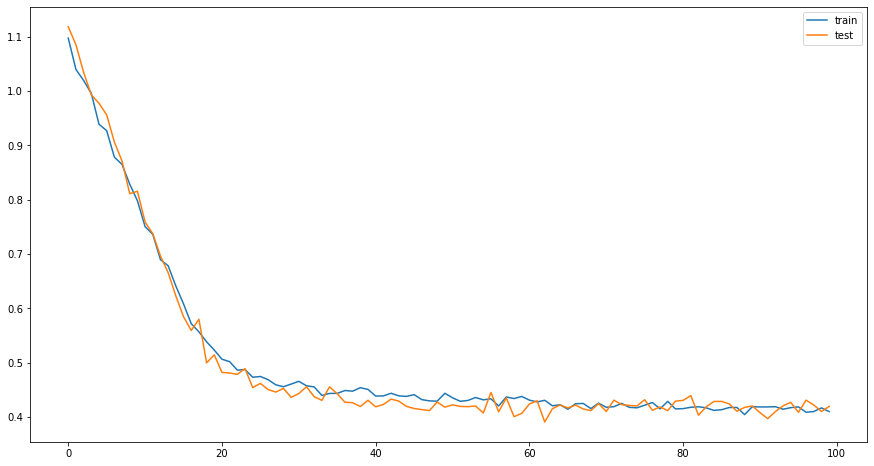

In [810]:
plot_loss(train_loss, test_loss)

In [811]:
def RMSE(true, preds):
    scaled_true = (true * std_temp) + mean_temp
    scaled_preds = (preds* std_temp) + mean_temp
    daily_rmse = (((scaled_true - scaled_preds)**2).mean(dim=0)**0.5)
    return daily_rmse, daily_rmse.mean().item()

In [812]:
def predict_last(X):
    return X[:,-PREDICT_PERIOD:]

In [813]:
def simple_pred(X):
    hist = X[:,-PREDICT_PERIOD:]
    guess = np.repeat(X[:,-PREDICT_PERIOD - 1], PREDICT_PERIOD).reshape(-1, PREDICT_PERIOD)
    return (hist + guess) / 2

In [814]:
net_preds = net(x_test)
hist_preds = predict_last(x_test)
simp_preds = simple_pred(x_test)

pred_rmse:2.612, hist_rmse:2.702, simple_rmse:2.638, diff:0.090


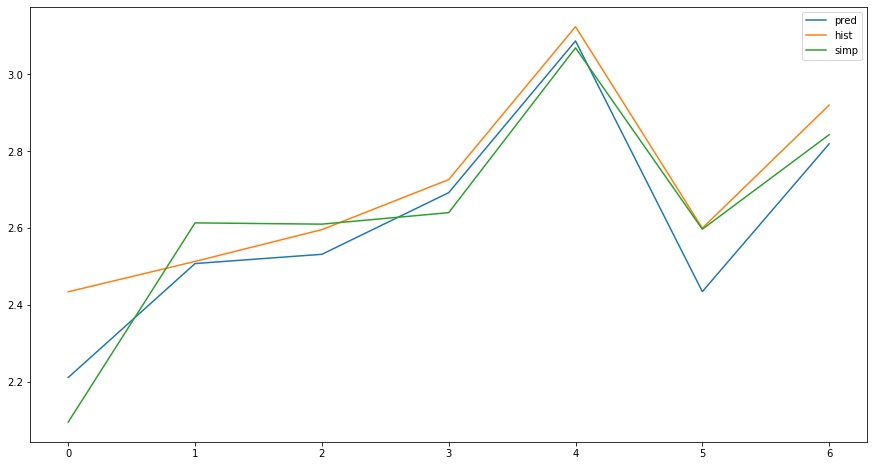

In [815]:
net_daily_acc, net_acc = RMSE(y_test, net_preds)
hist_daily_acc, hist_acc = RMSE(y_test, hist_preds)
simple_daily_acc, simple_acc = RMSE(y_test, simp_preds)
print(f"pred_rmse:{net_acc:.3f}, hist_rmse:{hist_acc:.3f}, simple_rmse:{simple_acc:.3f}, diff:{abs(net_acc - hist_acc):.3f}")
plt.figure(figsize=(15, 8))
plt.plot(net_daily_acc.detach().numpy(), label="pred")
plt.plot(hist_daily_acc.detach().numpy(), label="hist")
plt.plot(simple_daily_acc.detach().numpy(), label="simp")
plt.legend()
plt.show()

In [816]:
def plot_preds(y_true, preds, nrows=5):
    scaled_preds = (preds* std_temp) + mean_temp
    scaled_true = (y_true * std_temp) + mean_temp
    fig, axes = plt.subplots(nrows, 1, figsize=(15, 10))
    for i, ax in enumerate(axes):
        ax.plot(scaled_true[i].detach().numpy(), label="True")
        ax.plot(scaled_preds[i].detach().numpy(), "o", label="Pred")
    plt.legend()
    plt.show()

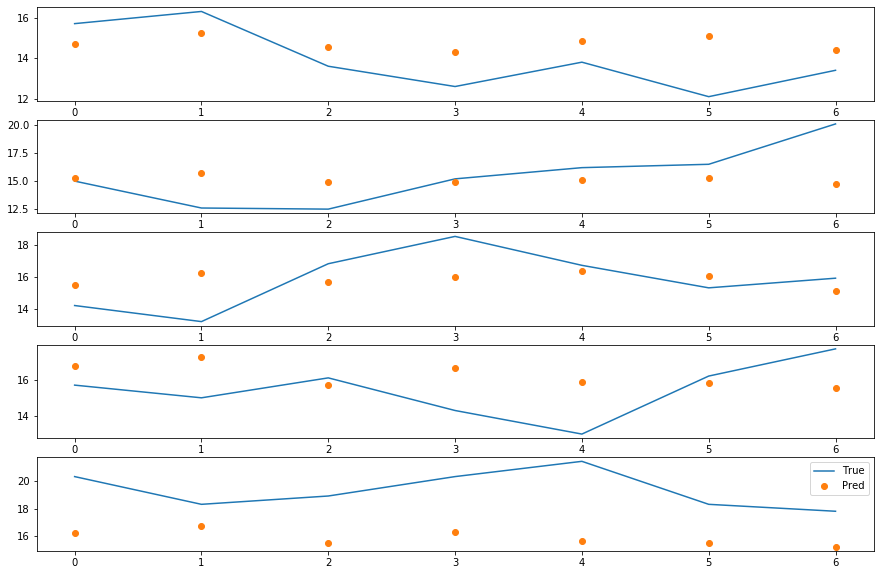

In [817]:
plot_preds(y_test, net_preds)